# The Unified Planning Library

In this demo we will scratch the surface of the UP: we will set it up, we manually create the blocksworld domain using the UP API, we create a problem using a bit of python and we solve the problem using different engines and a parallel composition of engines.

## Setup of the library

For this demo, we only need the following two shell commands. The first installs `libgraphviz` used for the plotting of graphs, the second installs the UP library, the set of default planning engines (namely: aries, enhsp, fast-downward, fmap, lpg, pyperplan, symk and tamer) and the optional python library dependecies for plotting.

In [ ]:
# Please note that these are included in the course container - uncomment if you want to run on colab

# !apt install graphviz graphviz-dev
# !pip install unified-planning[engines,plot]

## Modeling the Blocksworld domain

We will give a more in-detail description of the API later, here we just show a basic blocksworld domain encoded in Python using the UP API.

In [1]:
from unified_planning.model.types import BOOL
from unified_planning.shortcuts import *

# Create a new type (without parent)
Block = UserType("Block")

# The UP calls "fluents" both predicates and functions
# Each fluent has a type (BOOL for all fluents in this case) and might have parameters
clear = Fluent("clear", BOOL, obj=Block) # in PDDL this would be (clear ?obj - Block)
on_table = Fluent("on-table", BOOL, obj=Block)
arm_empty = Fluent("arm-empty", BOOL)
holding = Fluent("holding", BOOL, obj=Block)
on = Fluent("on", BOOL, above=Block, below=Block)

# Pickup action with one parameter a precondition formula and some effects
pickup = InstantaneousAction("pickup", obj=Block)
pickup.add_precondition(clear(pickup.obj) & on_table(pickup.obj) & arm_empty)
pickup.add_effect(holding(pickup.obj), True)
pickup.add_effect(clear(pickup.obj), False)
pickup.add_effect(on_table(pickup.obj), False)
pickup.add_effect(arm_empty, False)

# More actions...
putdown = InstantaneousAction("putdown", obj=Block)
putdown.add_precondition(holding(putdown.obj))
putdown.add_effect(holding(putdown.obj), False)
putdown.add_effect(clear(putdown.obj), True)
putdown.add_effect(on_table(putdown.obj), True)
putdown.add_effect(arm_empty, True)

stack = InstantaneousAction("stack", obj=Block, underobj=Block)
# More than one precondition can be set (implicit conjunction)
stack.add_precondition(clear(stack.underobj) & holding(stack.obj))
stack.add_precondition(Not(Equals(stack.obj, stack.underobj)))
stack.add_effect(arm_empty, True)
stack.add_effect(clear(stack.obj), True)
stack.add_effect(on(stack.obj, stack.underobj), True)
stack.add_effect(clear(stack.underobj), False)
stack.add_effect(holding(stack.obj), False)

unstack = InstantaneousAction("unstack", obj=Block, underobj=Block)
unstack.add_precondition(on(unstack.obj, unstack.underobj) & clear(unstack.obj) & arm_empty)
unstack.add_effect(holding(unstack.obj), True)
unstack.add_effect(clear(unstack.underobj), True)
unstack.add_effect(on(unstack.obj, unstack.underobj), False)
unstack.add_effect(clear(unstack.obj), False)
unstack.add_effect(arm_empty, False)

# So far we just created objects in memory, we have not yet declared a problem
# A `Problem` is a planning instance, but as a mutable object it can be partially specified
# Here we just add fluents and actions, so we represent the "domain"
problem = Problem("blocksworld")
for f in [clear, on_table, arm_empty, holding, on]:
  # We can specify arbitrary default initial values (particularly useful for numeric fluents)
  problem.add_fluent(f, default_initial_value=False)
problem.add_actions([pickup, putdown, stack, unstack])

# We can meaningfully print most UP objects for debug purposes
print(problem)

problem name = blocksworld

types = [Block]

fluents = [
  bool clear[obj=Block]
  bool on-table[obj=Block]
  bool arm-empty
  bool holding[obj=Block]
  bool on[above=Block, below=Block]
]

actions = [
  action pickup(Block obj) {
    preconditions = [
      ((clear(obj) and on-table(obj)) and arm-empty)
    ]
    effects = [
      holding(obj) := true
      clear(obj) := false
      on-table(obj) := false
      arm-empty := false
    ]
  }
  action putdown(Block obj) {
    preconditions = [
      holding(obj)
    ]
    effects = [
      holding(obj) := false
      clear(obj) := true
      on-table(obj) := true
      arm-empty := true
    ]
  }
  action stack(Block obj, Block underobj) {
    preconditions = [
      (clear(underobj) and holding(obj))
      (not (obj == underobj))
    ]
    effects = [
      arm-empty := true
      clear(obj) := true
      on(obj, underobj) := true
      clear(underobj) := false
      holding(obj) := false
    ]
  }
  action unstack(Block obj, Block unde

## Modeling a simple problem

We create a simple problem showing how to use python "data".
We create a problem where the goal is to stack 6 blocks labeled "m", "e", "d", "o" to form the word "demo" (where "d" is on top and "o" is on the table).  

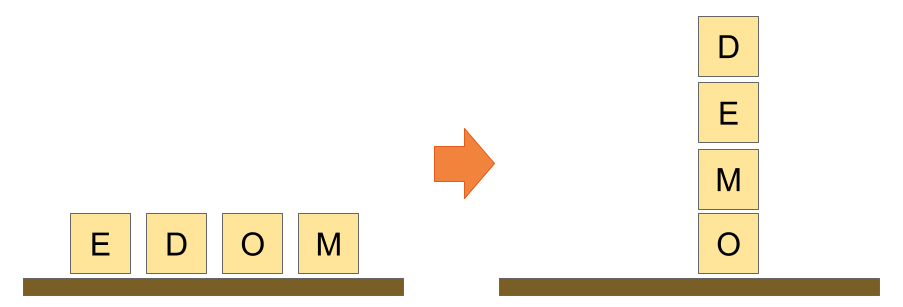

In [2]:
str_goal = "demo" # this is the "python data"

# we create the 6 objects programmatically
objects = [Object(x, Block) for x in str_goal]
problem.add_objects(objects)

# Set the initial state (all fluents are false by default because of the domain specification)
problem.set_initial_value(arm_empty, True)
for o in objects:
  problem.set_initial_value(on_table(o), True)
  problem.set_initial_value(clear(o), True)

# Set the goal
base = objects[0]
for o in objects[1:]:
  problem.add_goal(on(base, o))
  base = o

# Print the full planning instance
print(problem)

problem name = blocksworld

types = [Block]

fluents = [
  bool clear[obj=Block]
  bool on-table[obj=Block]
  bool arm-empty
  bool holding[obj=Block]
  bool on[above=Block, below=Block]
]

actions = [
  action pickup(Block obj) {
    preconditions = [
      ((clear(obj) and on-table(obj)) and arm-empty)
    ]
    effects = [
      holding(obj) := true
      clear(obj) := false
      on-table(obj) := false
      arm-empty := false
    ]
  }
  action putdown(Block obj) {
    preconditions = [
      holding(obj)
    ]
    effects = [
      holding(obj) := false
      clear(obj) := true
      on-table(obj) := true
      arm-empty := true
    ]
  }
  action stack(Block obj, Block underobj) {
    preconditions = [
      (clear(underobj) and holding(obj))
      (not (obj == underobj))
    ]
    effects = [
      arm-empty := true
      clear(obj) := true
      on(obj, underobj) := true
      clear(underobj) := false
      holding(obj) := false
    ]
  }
  action unstack(Block obj, Block unde

## OneshotPlanner Operation Mode

### Solving the problem with any engine

The UP can analyze a problem specification and filter the engines that can solve a certain problem. It does so by a data structure called `ProblemKind` (more on this later).

We can inspect the `ProblemKind` of a problem by using the `kind` property.

In [3]:
print(problem.kind)

PROBLEM_CLASS: ['ACTION_BASED']
CONDITIONS_KIND: ['NEGATIVE_CONDITIONS', 'EQUALITIES']
TYPING: ['FLAT_TYPING']


We can ask the UP to solve the problem using any suitable engine (a preference list is provided, a user can edit it programmatically or provide a custom configuation file: https://unified-planning.readthedocs.io/en/latest/engines.html#engine-selection-and-preference-list).

`OneshotPlanner` is the basic planning operation mode: given a problem find a plan

In [4]:
# Ask the UP to instantiate for us a "oneshot" planner supporting our problem kind
with OneshotPlanner(problem_kind=problem.kind) as planner:
  res = planner.solve(problem)
  print(res)

NOTE: To disable printing of planning engine credits, add this line to your code: `up.shortcuts.get_environment().credits_stream = None`
  *** Credits ***
  * In operation mode `OneshotPlanner` at line 2 of `/tmp/ipykernel_998726/4034772928.py`, you are using the following planning engine:
  * Engine name: Fast Downward
  * Developers:  Uni Basel team and contributors (cf. https://github.com/aibasel/downward/blob/main/README.md)
  * Description: Fast Downward is a domain-independent classical planning system.

status: SOLVED_SATISFICING
engine: Fast Downward
plan: SequentialPlan:
    pickup(m)
    stack(m, o)
    pickup(e)
    stack(e, m)
    pickup(d)
    stack(d, e)


The `unified_planning.plot` package provides useful functions to visually plot many objects

  *** Credits ***
  * In operation mode `Compiler` at line 136 of `/home/vscode/.local/lib/python3.8/site-packages/unified_planning/plot/causal_graph_plot.py`, you are using the following planning engine:
  * Engine name: Tarski grounder
  * Developers:  Artificial Intelligence and Machine Learning Group - Universitat Pompeu Fabra
  * Description: Tarski grounder, more information available on the given website.



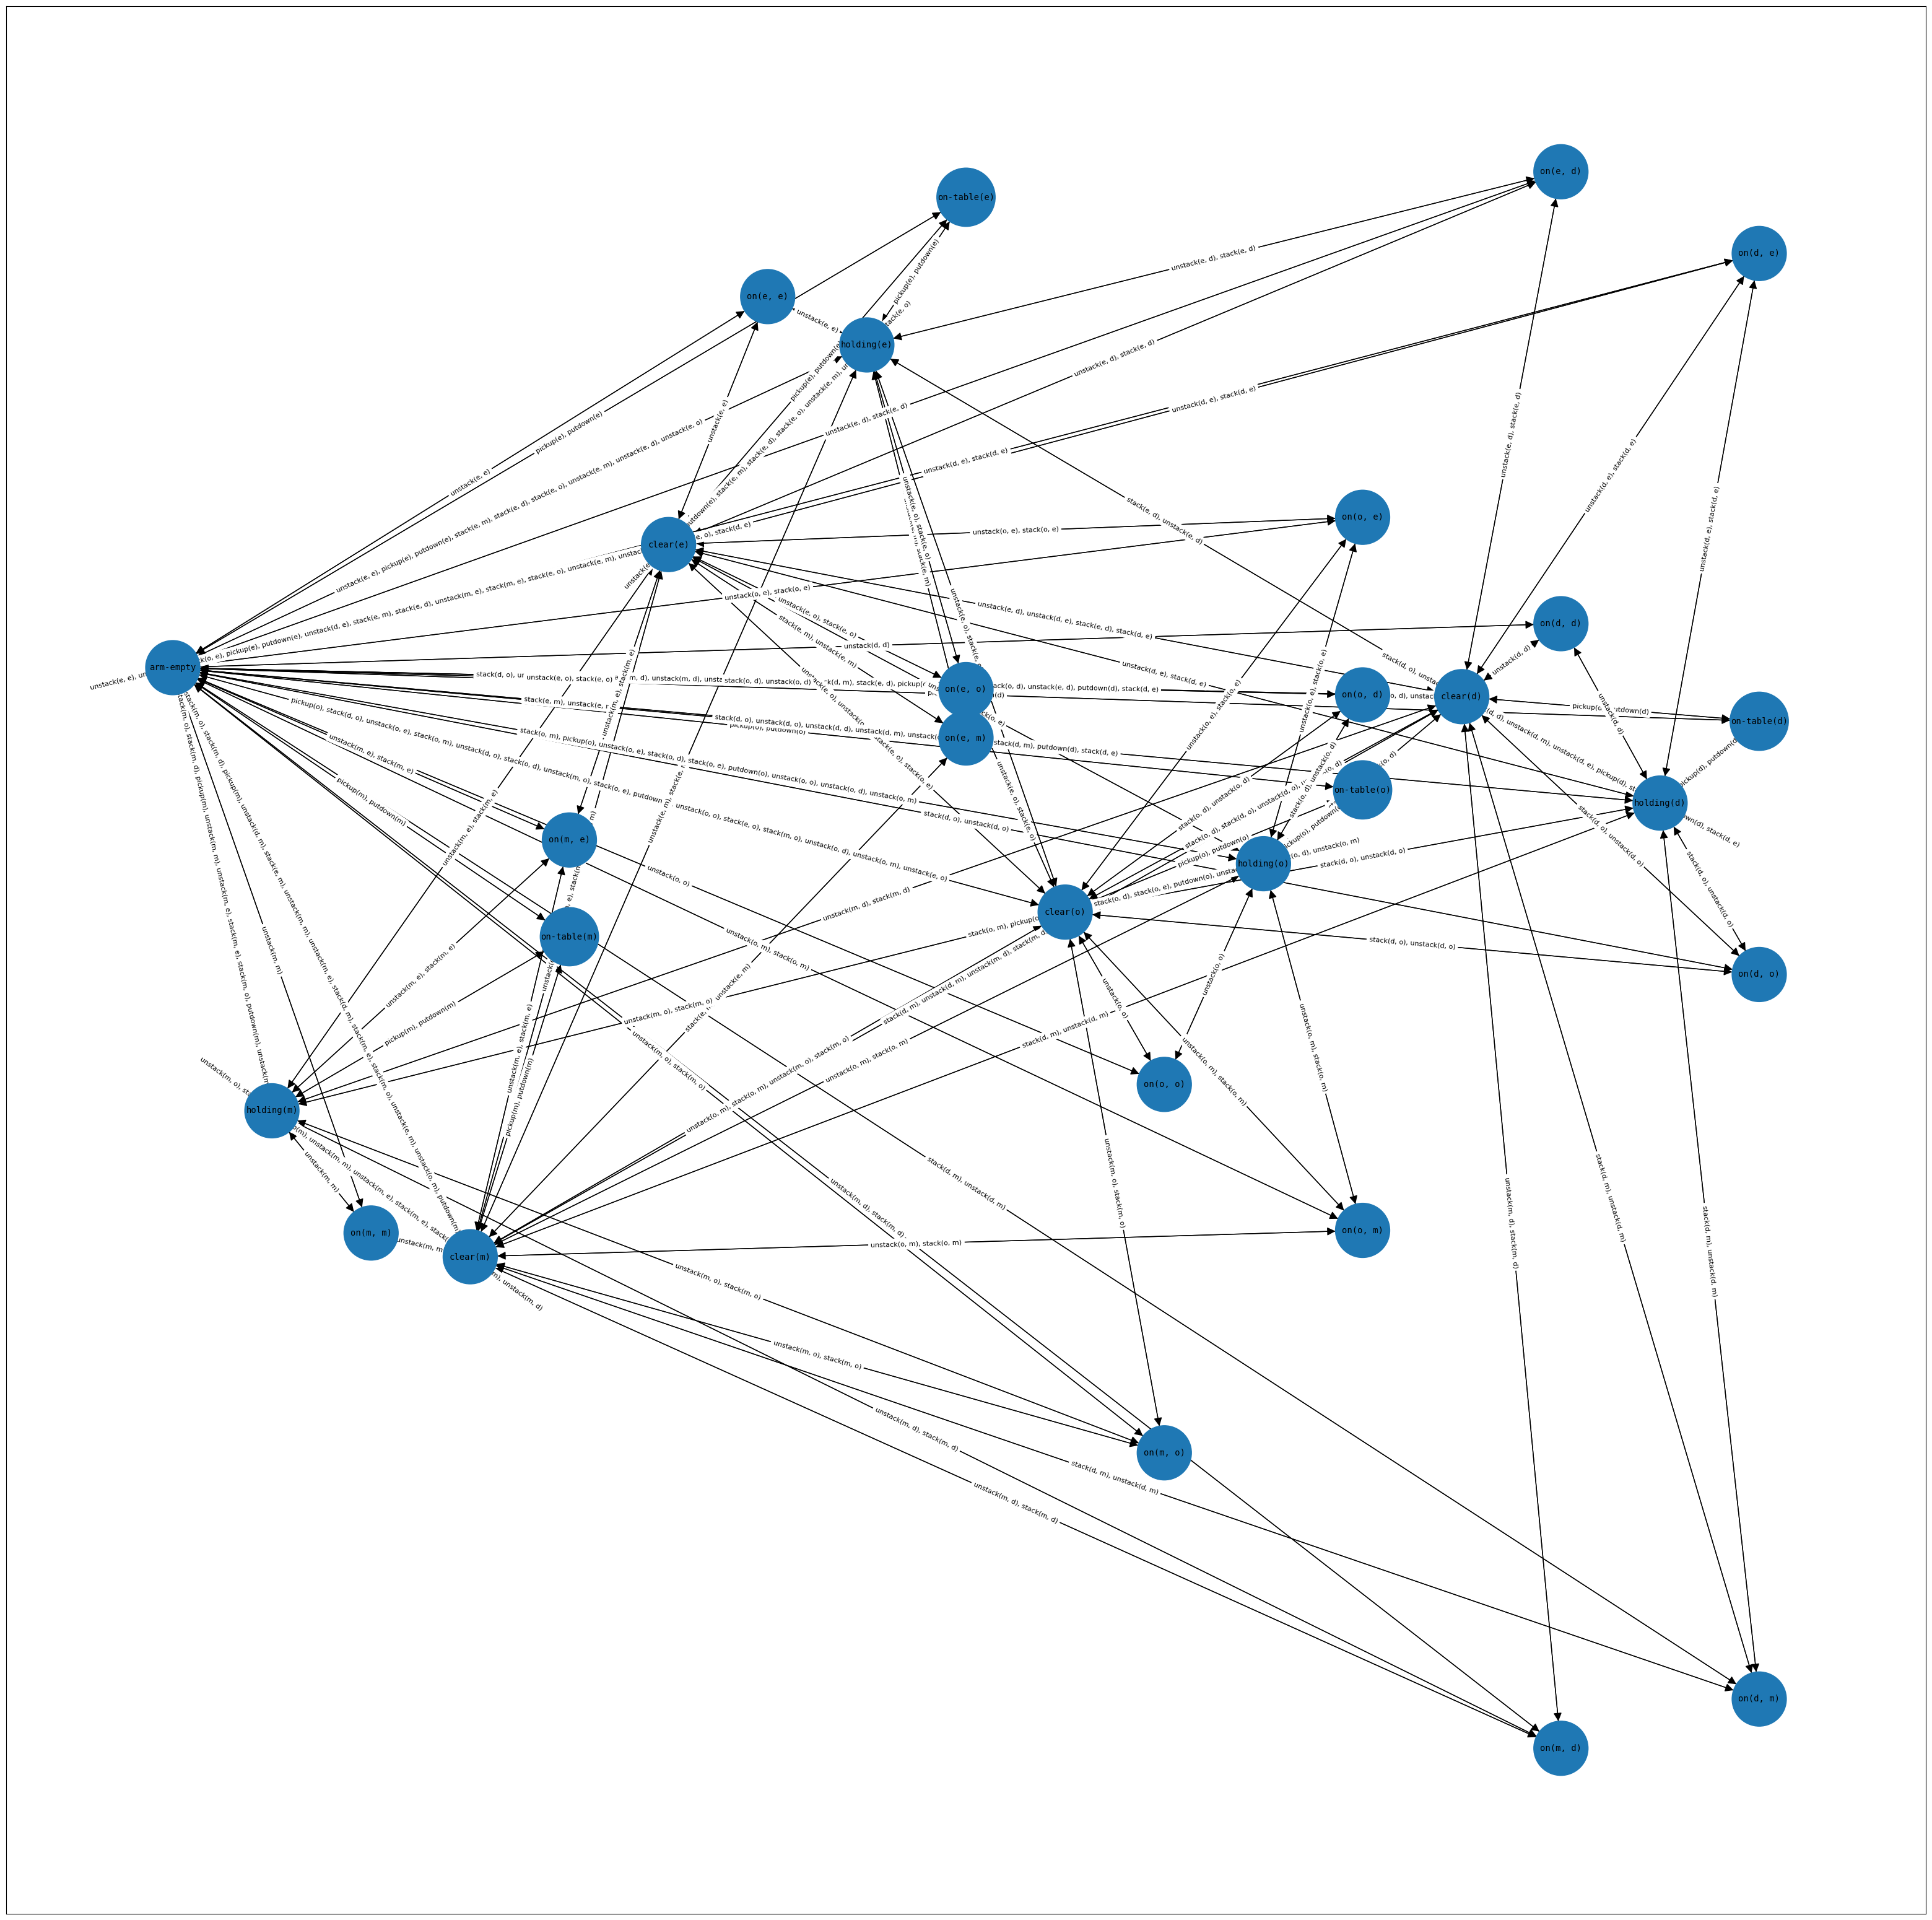

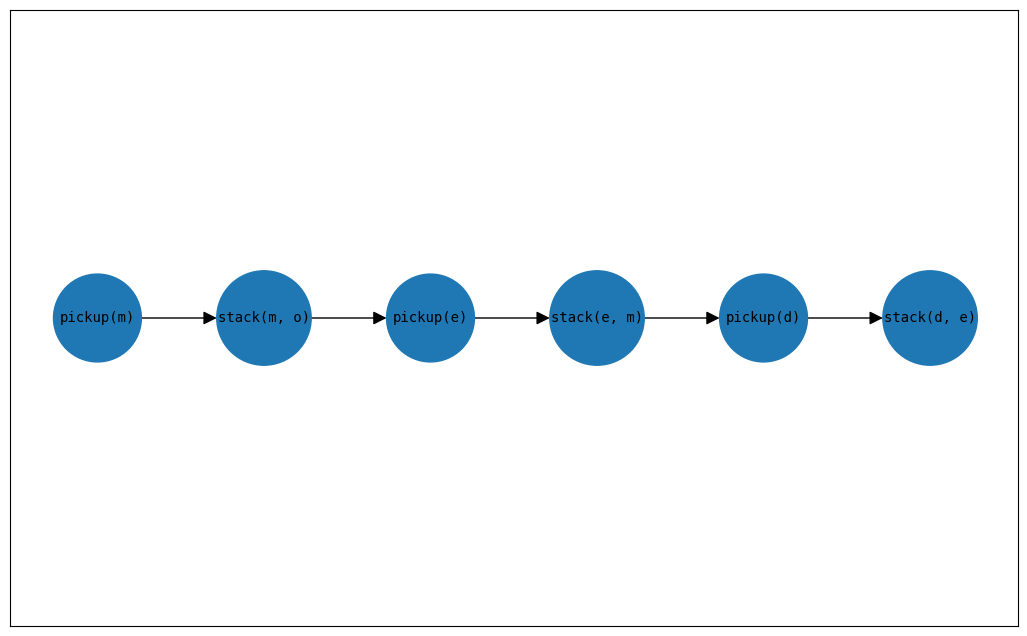

In [5]:
import unified_planning.plot as plt

plt.plot_causal_graph(problem=problem,figsize=(40,40))
plt.plot_plan(res.plan)

### Specifying the engine name
We can also explicitly specify the name of the engine we want to use (and optionally custom parameters). The interface, after the openation mode is identical.

In [6]:
with OneshotPlanner(name="lpg") as planner:
  res = planner.solve(problem)
  print(res)

  *** Credits ***
  * In operation mode `OneshotPlanner` at line 1 of `/tmp/ipykernel_998726/719035379.py`, you are using the following planning engine:
  * Engine name: LPG
  * Developers:  UNIBS Team
  * Description: LPG is a planner based on local search and planning graphs.

status: SOLVED_SATISFICING
engine: lpg
plan: SequentialPlan:
    pickup(d)
    stack(d, e)
    pickup(m)
    stack(m, o)
    unstack(d, e)
    putdown(d)
    pickup(e)
    stack(e, m)
    pickup(d)
    stack(d, e)


/home/vscode/.local/lib/python3.8/site-packages/unified_planning/engines/mixins/oneshot_planner.py:76: UserWarning: We cannot establish whether lpg can solve this problem!
  warn(msg)


### Parallel solving
We can even execute more than one planner in parallel and use this "parallel portfolio" as a normal planner.

In [7]:
with OneshotPlanner(names=["tamer", "fast-downward"]) as planner:
  res = planner.solve(problem)
  print(res)

  *** Credits ***
  * In operation mode `OneshotPlanner` at line 1 of `/tmp/ipykernel_998726/1972089550.py`, you are using a parallel planning engine with the following components:
  * Engine name: Tamer
  * Developers:  FBK Tamer Development Team
  * Description: Tamer offers the capability to generate a plan for classical, numerical and temporal problems.
  *              For those kind of problems tamer also offers the possibility of validating a submitted plan.
  * Engine name: Fast Downward
  * Developers:  Uni Basel team and contributors (cf. https://github.com/aibasel/downward/blob/main/README.md)
  * Description: Fast Downward is a domain-independent classical planning system.



status: SOLVED_SATISFICING
engine: Tamer
plan: SequentialPlan:
    pickup(m)
    stack(m, o)
    pickup(e)
    stack(e, m)
    pickup(d)
    stack(d, e)


### The interface is the same!

All engines supporting an OperationMode are required to support the same interface and being interchangeable.

In [8]:
all_applicable_planners = get_all_applicable_engines(problem_kind=problem.kind, operation_mode=OperationMode.ONESHOT_PLANNER)
print(all_applicable_planners)

['fast-downward', 'fast-downward-opt', 'symk', 'symk-opt', 'enhsp', 'enhsp-opt', 'enhsp-any', 'tamer', 'aries', 'oversubscription[fast-downward]', 'oversubscription[fast-downward-opt]', 'oversubscription[symk]', 'oversubscription[symk-opt]', 'oversubscription[enhsp]', 'oversubscription[enhsp-opt]', 'oversubscription[enhsp-any]', 'oversubscription[tamer]', 'oversubscription[aries]']


In [9]:
for pname in all_applicable_planners:
  with OneshotPlanner(name=pname) as planner:
    res = planner.solve(problem)
    print(res)

  *** Credits ***
  * In operation mode `OneshotPlanner` at line 2 of `/tmp/ipykernel_998726/3657586449.py`, you are using the following planning engine:
  * Engine name: Fast Downward
  * Developers:  Uni Basel team and contributors (cf. https://github.com/aibasel/downward/blob/main/README.md)
  * Description: Fast Downward is a domain-independent classical planning system.



status: SOLVED_SATISFICING
engine: Fast Downward
plan: SequentialPlan:
    pickup(m)
    stack(m, o)
    pickup(e)
    stack(e, m)
    pickup(d)
    stack(d, e)
  *** Credits ***
  * In operation mode `OneshotPlanner` at line 2 of `/tmp/ipykernel_998726/3657586449.py`, you are using the following planning engine:
  * Engine name: Fast Downward
  * Developers:  Uni Basel team and contributors (cf. https://github.com/aibasel/downward/blob/main/README.md)
  * Description: Fast Downward is a domain-independent classical planning system.

status: SOLVED_SATISFICING
engine: Fast Downward (with optimality guarantee)
plan: SequentialPlan:
    pickup(m)
    stack(m, o)
    pickup(e)
    stack(e, m)
    pickup(d)
    stack(d, e)
  *** Credits ***
  * In operation mode `OneshotPlanner` at line 2 of `/tmp/ipykernel_998726/3657586449.py`, you are using the following planning engine:
  * Engine name: SymK
  * Developers:  David Speck (cf. https://github.com/speckdavid/symk/blob/master/README.md )
  

FileNotFoundError: [Errno 2] No such file or directory: 'java'